In [1]:
# 模型训练
import numpy as np
import pandas as pd
import os
import tqdm

base_path = 'stock'

market_map = {'主板':0, '中小板':1}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16, 
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24, 
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6, 
 '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13, 
 'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20, 
 '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
 '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
 '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44, 
 '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52, 
 '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60, 
 '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68, 
 '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77, 
 '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85, 
 '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
 '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102, 
 '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

# 数据读取

In [2]:
def JudgeST(x):
    if 'ST' in x:
        return 1
    else:
        return 0
    
col = ['open', 'high', 'low', 'pre_close',]

def GetMA(df, col_name, rolling_day):
    df[col_name + '_'+str(rolling_day)] = df[col_name].rolling(rolling_day).mean()
    return df

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'), encoding='ANSI')
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(['index', 'symbol', 'fullname'], axis=1, inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)


# 读取指数信息
stock_index_info = pd.DataFrame()
index = ['000001.SH', '000016.SH', '000002.SH', '399001.SZ', '399007.SZ', '399008.SZ', '399101.SZ',
         '399102.SZ']
for ts_code in index:
    tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    # 特征工程
#         tmp_df = FeatureEngineering(tmp_df)
    stock_index_info = pd.concat((stock_index_info, tmp_df)) 
#     transaction_day = len(tmp_df) 
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
for ts_code in tqdm.tqdm(company_info['ts_code']):
    tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    
    # 还需要去除一些停牌时间很久的企业，后期加
    if len(tmp_df) < 100:  # 去除一些上市不久的企业
        remove_stock.append(ts_code)
        continue
    tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index()
#         提取均线信息
#     for tmp_col in col:
#         for rolling_day in [5, 10, 13, 21, 30]:
#             tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
    # 特征工程
#         tmp_df = FeatureEngineering(tmp_df)
    tmp_list.append(tmp_df)
stock_info = pd.concat(tmp_list)
ts_code_map = dict(zip(stock_info['ts_code'].unique(), range(stock_info['ts_code'].nunique())))
stock_info = stock_info.reset_index()
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)
stock_info.drop('index', axis=1, inplace=True)
stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
stock_info['ts_date_id'] = (10000 + stock_info['ts_code_id']) * 10000 + stock_info['trade_date_id']
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

100%|██████████| 2890/2890 [00:25<00:00, 112.01it/s]


# 特征工程

In [3]:
stock_info = stock_info_copy.copy()
col = ['close', 'open', 'high', 'low']
feature_col = []
for tmp_col in col:
    stock_info[tmp_col+'_'+'transform'] = (stock_info[tmp_col] - stock_info['pre_close']) / stock_info['pre_close']
    feature_col.append(tmp_col+'_'+'transform')

In [4]:
for i in range(5):
    tmp_df = stock_info[['ts_date_id', 'close']]
    tmp_df = tmp_df.rename(columns={'close':'close_shift_{}'.format(i+1)})
    feature_col.append('close_shift_{}'.format(i+1))
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
stock_info.drop('level_0', axis=1, inplace=True)
# stock_info.dropna(inplace=True)

for i in range(5):
    stock_info['close_shift_{}'.format(i+1)] = (stock_info['close'] - stock_info['close_shift_{}'.format(i+1)]) / stock_info['close_shift_{}'.format(i+1)]

# 标签制作

In [5]:
# make_label
# stock_info = stock_info_copy.copy()
use_col = []
for i in range(5):
    tmp_df = stock_info[['ts_date_id', 'high', 'low']]
    tmp_df = tmp_df.rename(columns={'high':'high_shift_{}'.format(i+1), 'low':'low_shift_{}'.format(i+1)})
    use_col.append('high_shift_{}'.format(i+1))
    use_col.append('low_shift_{}'.format(i+1))
    tmp_df['ts_date_id'] = tmp_df['ts_date_id'] - i - 1
    stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')

stock_info.dropna(inplace=True)

for i in range(5):
    stock_info['high_shift_{}'.format(i+1)] = (stock_info['high_shift_{}'.format(i+1)] - stock_info['close']) / stock_info['close']
    stock_info['low_shift_{}'.format(i+1)] = (stock_info['low_shift_{}'.format(i+1)] - stock_info['close']) / stock_info['close']

tmp_array = stock_info[use_col].values
max_increse = np.max(tmp_array, axis=1)
min_increse = np.min(tmp_array, axis=1)
stock_info['label_max'] = max_increse
stock_info['label_min'] = min_increse
stock_info['label_final'] = (stock_info['label_max'] > 0.06) & (stock_info['label_min'] > -0.03)
stock_info['label_final'] = stock_info['label_final'].apply(lambda x: int(x))
stock_info = stock_info.reset_index()
stock_info.drop('index', axis=1, inplace=True)

# 模型训练

In [6]:

trn_col = ['open', 'high', 'low', 'close', 'pre_close', 'change', 'pct_chg', 'vol', 'amount', 'ts_code_id'] + feature_col
label = 'label_final'
trn_date_min = 20180101
trn_date_max = 20190405
val_date_min = 20190406
val_date_max = 20190410
test_date_min = 20190417
test_date_max = 20191218

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max)
val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col].values
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col].values
val_label = stock_info[val_data_idx][label].values 

test = stock_info[test_data_idx][trn_col].values
test_label = stock_info[test_data_idx][label].values

In [7]:
print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('number of features:%d' % len(trn_col))

rate of 0: 0.7934, rate of 1: 0.2066
trn data:807864, val data:8329, test data:468603
number of features:19


In [8]:
# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics
param = {'num_leaves': 31,
         #              'n_estimatores': 3000,
         'min_data_in_leaf': 20,
         'objective': 'binary',
#          'max_depth': 5,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
#          "feature_fraction": 0.45,
         "bagging_freq": 1,
#          "bagging_fraction": 0.8,
         "bagging_seed": 11,
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round = 2000
clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=300,
                early_stopping_rounds=100)
oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

Training until validation scores don't improve for 100 rounds.
[300]	training's binary_logloss: 0.492673	valid_1's binary_logloss: 0.400848
[600]	training's binary_logloss: 0.488755	valid_1's binary_logloss: 0.399869
[900]	training's binary_logloss: 0.48672	valid_1's binary_logloss: 0.399479
[1200]	training's binary_logloss: 0.48498	valid_1's binary_logloss: 0.399227
[1500]	training's binary_logloss: 0.483507	valid_1's binary_logloss: 0.39892
[1800]	training's binary_logloss: 0.482178	valid_1's binary_logloss: 0.398745
Did not meet early stopping. Best iteration is:
[2000]	training's binary_logloss: 0.481367	valid_1's binary_logloss: 0.398642


# 模型评价

In [9]:
oof_lgb_final = np.round(oof_lgb)
print(metrics.accuracy_score(val_label, oof_lgb_final))
print(metrics.confusion_matrix(val_label, oof_lgb_final))
tp = np.sum(((oof_lgb_final == 1) & (val_label == 1)))
pp = np.sum(oof_lgb_final == 1)
print('sensitivity:%.3f'% (tp/(pp)))

0.872133509424901
[[7259    5]
 [1060    5]]
sensitivity:0.500


In [10]:
thresh_hold = 0.6
oof_test_final = test_lgb >= thresh_hold
print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('sensitivity:%.3f'% (tp/(pp)))

0.8446424798816909
[[395738     64]
 [ 72737     64]]
sensitivity:0.500


In [11]:
test_postive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
test_all_idx = np.argwhere(test_data_idx).reshape(-1)

In [12]:
# 查看选了哪些股票
tmp_col = ['ts_code', 'name', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'amount', 'is_ST', 'label_max', 'label_min', 'label_final']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)

In [13]:
print(len(buy_df), sum(buy_df['label_final']))

46 12


# 回测

In [14]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

In [15]:
tmp_idx = (index_df['trade_date'] == test_date_min)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [16]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init)
account.BackTest(buy_df, stock_info_copy, index_df)

20190423  买入 三维工程 (002469.SZ) 3900股，股价：5.03,花费：19617.0,手续费：5.89，剩余现金：80377.11
20190424  买入 华铁应急 (603300.SH) 1900股，股价：10.18,花费：19342.0,手续费：5.8，剩余现金：61029.31
20190425  买入 贤丰控股 (002141.SZ) 4200股，股价：4.71,花费：19782.0,手续费：5.93，剩余现金：41241.38
20190425  止损卖出华铁应急 (603300.SH) 1900股，股价：9.7728,收入：18568.32,手续费：24.14，剩余现金：59785.56，最终亏损：-803.62
20190425  止损卖出三维工程 (002469.SZ) 3900股，股价：4.8288,收入：18832.32,手续费：24.48，剩余现金：78593.4，最终亏损：-815.05
20190426  止损卖出贤丰控股 (002141.SZ) 4200股，股价：4.521599999999999,收入：18990.72,手续费：24.69，剩余现金：97559.43，最终亏损：-821.9
20190507  买入 金发拉比 (002762.SZ) 3300股，股价：5.76,花费：19008.0,手续费：5.7，剩余现金：78545.73
20190507  买入 盘龙药业 (002864.SZ) 600股，股价：28.7,花费：17220.0,手续费：5.17，剩余现金：61320.56
20190507  买入 蒙娜丽莎 (002918.SZ) 800股，股价：23.03,花费：18424.0,手续费：5.53，剩余现金：42891.03
20190507  买入 恒铭达 (002947.SZ) 500股，股价：34.48,花费：17240.0,手续费：5.17，剩余现金：25645.86
20190507  买入 永泰能源 (600157.SH) 10000股，股价：1.95,花费：19500.0,手续费：5.85，剩余现金：6140.01
20190507  买入 怡球资源 (601388.SH) 3000股，股价：2.02,花费：6060.0,手续费：5，剩余现金：75.01
20190508  止

In [17]:
account.info

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit
0,002469.SZ,三维工程,5.03,20190423,3900,4.8288,20190425,-815.047
1,603300.SH,华铁应急,10.18,20190424,1900,9.7728,20190425,-803.621
2,002141.SZ,贤丰控股,4.71,20190425,4200,4.5216,20190426,-821.903
3,002762.SZ,金发拉比,5.76,20190507,3300,6.22,20190510,1485.61
4,002864.SZ,盘龙药业,28.7,20190507,600,29.24,20190513,296.027
5,002918.SZ,蒙娜丽莎,23.03,20190507,800,22.1088,20190508,-765.48
6,002947.SZ,恒铭达,34.48,20190507,500,36.204,20190508,833.295
7,600157.SH,永泰能源,1.95,20190507,10000,1.872,20190508,-810.186
8,601388.SH,怡球资源,2.02,20190507,3000,1.95,20190508,-225.85
9,600469.SH,风神股份,6.1,20190520,3200,5.9,20190521,-670.4


In [18]:
account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:0.0547
上证指数浮动情况:-0.0754
交易胜率:0.5263
最大回撤率:0.0545


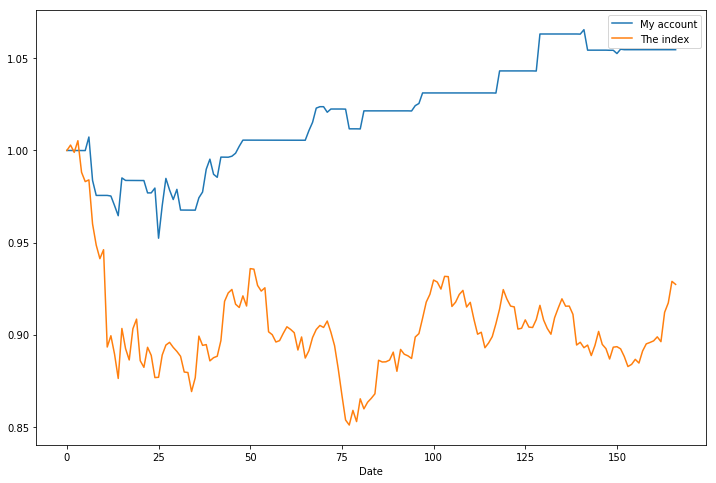

In [19]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)

E:\code\venv2\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


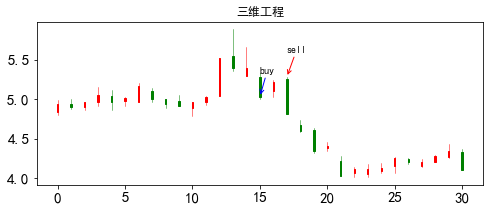

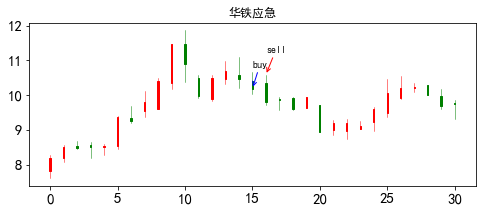

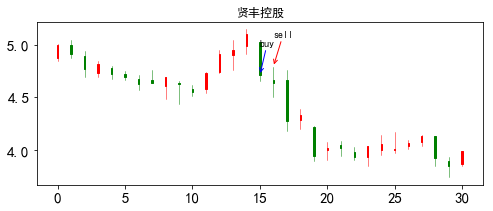

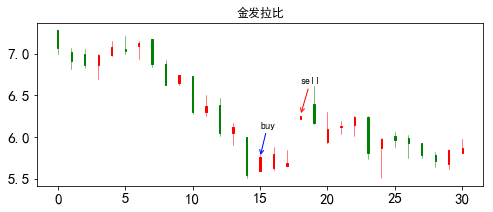

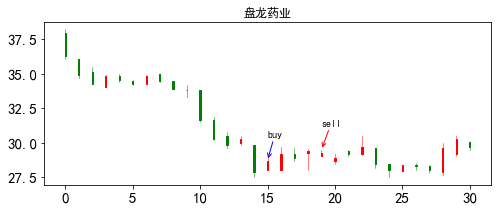

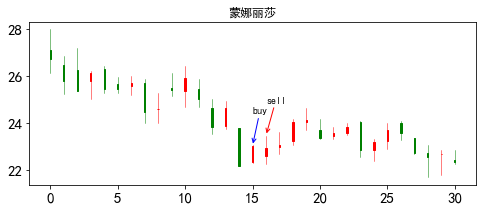

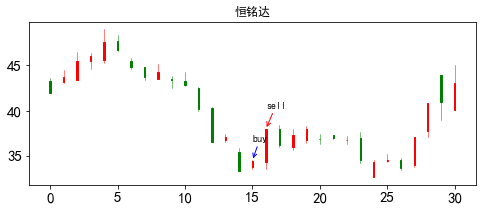

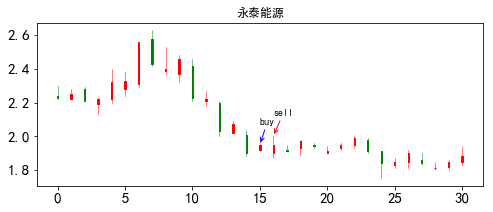

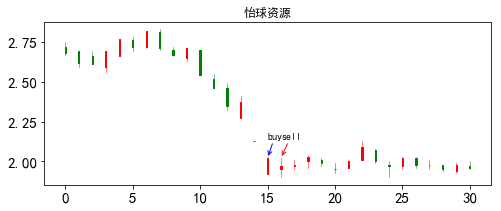

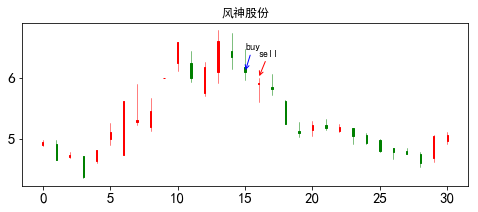

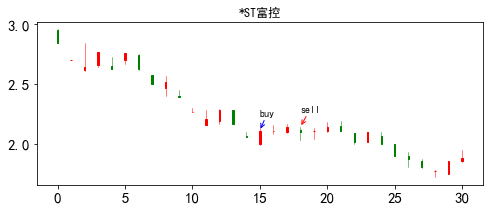

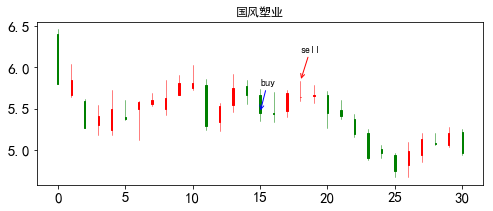

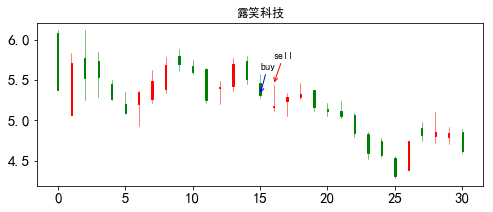

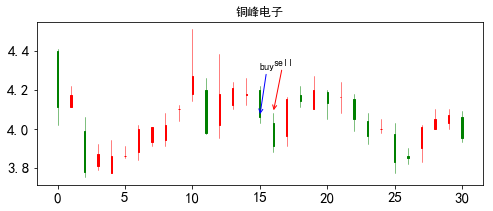

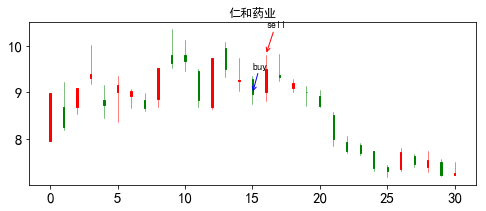

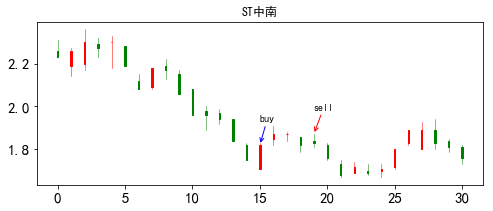

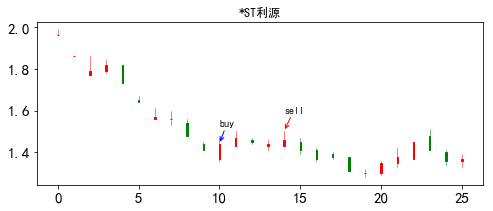

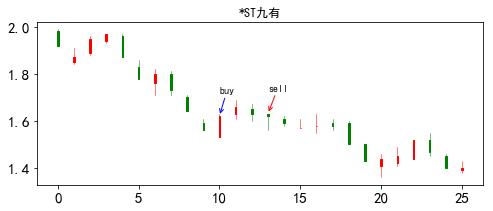

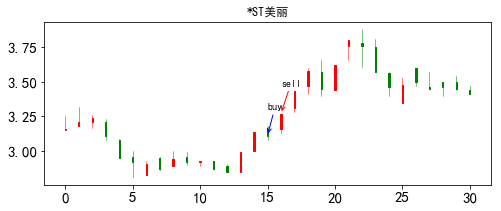

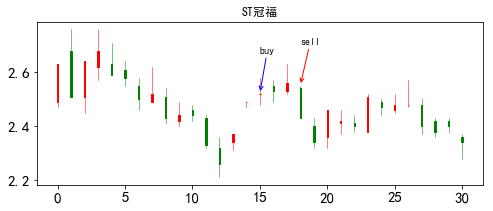

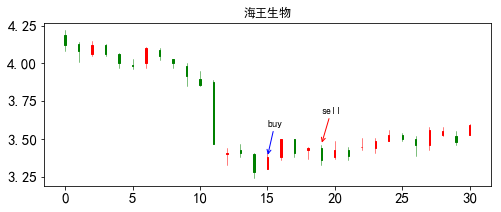

In [20]:
num = 0
for ts_code, buy_date, sell_date in zip(account.info['ts_code'], account.info['buy_date'], account.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=15, right_offset=15)
    num = num + 1
    if num > 20:
        break